In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

import os
import seaborn as sns
from scipy.sparse import coo_matrix
import gc

from tqdm.notebook import tqdm
import time

tqdm.pandas(desc="Processing Data")

In [2]:
DOC_PATH = "./data/trec-robust04/doc_vectors"
QRELS_PATH = "./data/trec-robust04/robust04.qrels"
QUERY_PATH = "./data/trec-robust04/desc-queries.tsv"
SAVE_TO_CACHE = False
COLLECT_ALL_SYMBOLS = True
CACHE_MEMORY_PATH = "./data/trec-robust04/cache_memory"
DELETE_ALL_CACHE = False
os.makedirs(CACHE_MEMORY_PATH, exist_ok=True)

In [3]:
if DELETE_ALL_CACHE:
    for file in os.listdir(CACHE_MEMORY_PATH):
        print("Removing:\t", CACHE_MEMORY_PATH + "/" + file)
        os.remove(CACHE_MEMORY_PATH + "/" + file)

In [4]:
if COLLECT_ALL_SYMBOLS:
    all_symbols = set()
    for files in os.listdir(DOC_PATH):
        df = pd.read_json(DOC_PATH + "/" + files, lines=True)
        df[["document", "segment"]] = df["id"].str.split("@@", expand=True)

        print("EXCTRACTING ALL SYMBOLS OF: \t", DOC_PATH + "/" + files)
        all_symbols = all_symbols.union(*df["vector"].apply(lambda x: x.keys()))

        del df
        gc.collect()  # force garbage collection

EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part41
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part28
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part45
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part23
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part40
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part27
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part58
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part22
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part09
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part04
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part57
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part21
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part08
EXCTRACTING ALL SYMBOLS OF: 	 ./data/trec-robust04/doc_vectors/part52
EXCTRACTING ALL SYMB

In [5]:
if SAVE_TO_CACHE or os.listdir(CACHE_MEMORY_PATH) == []:
    for files in os.listdir(DOC_PATH):
        print("STARTING\t", DOC_PATH + "/" + files)
        if files + ".pkl" in os.listdir(CACHE_MEMORY_PATH):
            print(f"skipping {CACHE_MEMORY_PATH}/{files}.pkl file as it already exits")
            continue
        print("READING: \t", DOC_PATH + "/" + files)
        df = pd.read_json(DOC_PATH + "/" + files, lines=True)
        df[["document", "segment"]] = df["id"].str.split("@@", expand=True)

        # Step 1: Define a function that converts JSON sparse vector to sparse matrix
        def json_to_sparse_vector(sparse_json, all_symbols):
            # Create index mapping from symbols to indices
            index_mapping = {symbol: idx for idx, symbol in enumerate(all_symbols)}

            # Convert sparse_json to indices and values
            indices = [index_mapping[symbol] for symbol in sparse_json.keys()]
            values = [sparse_json[symbol] for symbol in sparse_json.keys()]

            # Create a sparse vector (COO format) for this row
            sparse_vector = coo_matrix(
                (values, (np.zeros(len(indices)), indices)), shape=(1, len(all_symbols))
            )

            # Convert to CSR for efficiency
            return sparse_vector.tocsr()

        print("EXCTRACTING SPARSE VECTORS OF: \t", DOC_PATH + "/" + files)
        df["sparse_matrix"] = df["vector"].apply(
            lambda x: json_to_sparse_vector(x, all_symbols)
        )

        print("SAVING: \t", DOC_PATH + "/" + files + ".pkl")
        df.to_pickle(CACHE_MEMORY_PATH + "/" + files + ".pkl")

        del df
        gc.collect()  # force garbage collection
        print("FINISHED WITH: \t", DOC_PATH + "/" + files)

In [6]:
THE_MAIN_SEGMENT = None
THE_OTHER_SEGMENT = None
FUNCTION_2_USE = None
CONSTANT_NUMBER = None


def compare(df, pair, function_2_use):
    x_pair, y_pair = pair
    global THE_MAIN_SEGMENT
    global THE_OTHER_SEGMENT
    global FUNCTION_2_USE

    THE_MAIN_SEGMENT = x_pair
    THE_OTHER_SEGMENT = y_pair
    FUNCTION_2_USE = function_2_use
    return df.groupby("document").apply(function_2_use, include_groups=False)


# def function_main_vs_other(group_df):
#     main_seg_score = group_df.loc[
#         group_df["segment"] == str(THE_MAIN_SEGMENT), "sparse_matrix"
#     ].values
#     other_seg_score = group_df.loc[
#         group_df["segment"] == THE_OTHER_SEGMENT, "sparse_matrix"
#     ].values

#     # Calculate MAE between the first segment score and the rest of the segments
#     if (
#         len(main_seg_score) > 0 and len(other_seg_score) > 0
#     ):  # Ensure there are other segments to compare
#         main_seg_array = main_seg_score[0].toarray()[0]
#         other_seg_array = other_seg_score[0].toarray()[0]

#         function_value = abs_error(main_seg_array, other_seg_array)

#         return function_value
#     else:
#         return None


# def abs_error(x, y):
#     return np.sum(np.abs(x - y))


def create_plot(list_dfs,spacing=1):
    colors = sns.color_palette("colorblind", len(list_dfs))
    plt.figure(figsize=(12, 8))  # Create a figure once to plot all dataframes
    plt.rcParams.update({"font.size": 30})  # Set to your desired size

    captions = []

    
    for index, values in enumerate(list_dfs):
        df, pair = values
        
        df = df.dropna()

        # q99 = df.quantile(0.99)
        # q1 = df.quantile(0.01)
        normalized_df = (df - df.mean()) / df.std()
        
        # Clip values to handle outliers
        # normalized_df = normalized_df.clip(lower=0,upper=100)

        sr = normalized_df.dropna()

        sr = df.dropna()

        if isinstance(pair[1], list) and len(pair[1]) > 1:
            the_other = ",".join([str(i) for i in pair[1]])
            caption = f"{str(pair[0])} - {the_other}\nμ:{str(np.round(sr.mean(), 2))}\nσ:{str(np.round(sr.std(), 2))}"
        elif not isinstance(pair[1], int):
            caption = f"{str(pair[0])} - {str(pair[1][0])}\nμ:{str(np.round(sr.mean(), 2))}\nσ:{str(np.round(sr.std(), 2))}"
        else:
            caption = f"{str(pair[0])} - {str(pair[1])}\nμ:{str(np.round(sr.mean(), 2))}\nσ:{str(np.round(sr.std(), 2))}"

        captions.append(caption)

        ax = sns.violinplot(
            data=sr.dropna().to_frame(caption),
            inner="box", 
            orient="v",
            bw_adjust=.7,
            color=colors[index],
            # inner_kws=dict(box_width=15, whis_width=2, color=".8")
        )

    plt.xticks(
        [i * spacing for i in range(len(list_dfs))],
        captions,
        # rotation=45,
        ha='center'
    )

    
    # Add padding to prevent label cutoff
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.ylim(0,1)
    plt.ylabel('Normalized Frequency')
    plt.show()

# create_plot(all_dfs,spacing=1)

Total common btw 2 segs

READING: 	 ./data/trec-robust04/cache_memory/part09.pkl
time took: 22.673118591308594
READING: 	 ./data/trec-robust04/cache_memory/part08.pkl


time took: 16.845706462860107
READING: 	 ./data/trec-robust04/cache_memory/part39.pkl
time took: 29.578502416610718
The results:
Total number of documents for (1, 2) pair is: 12207
Total number of documents for (1, 3) pair is: 5234
Total number of documents for (1, 4) pair is: 2748
Total number of documents for (1, 6) pair is: 1047


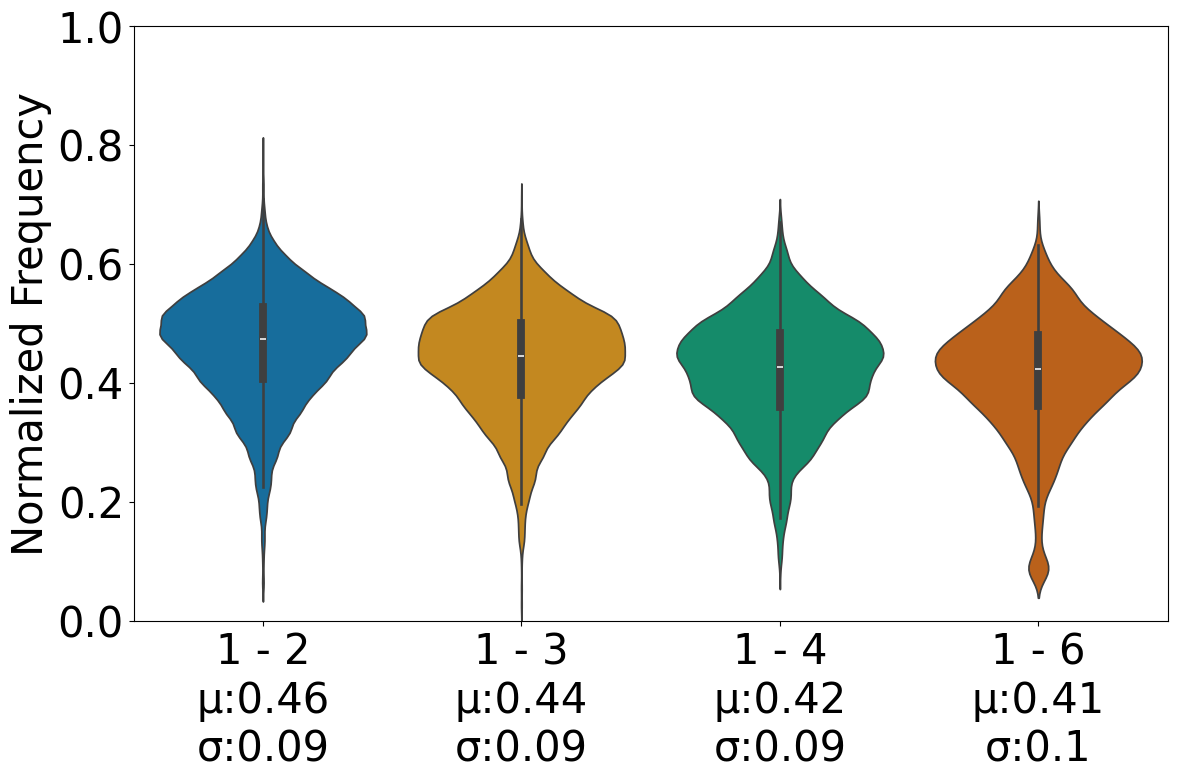

In [7]:
def function_main_vs_other_binary(group_df):
    main_seg_score = group_df.loc[
        group_df["segment"] == THE_MAIN_SEGMENT, "sparse_matrix"
    ].values
    other_seg_score = group_df.loc[
        group_df["segment"] == THE_OTHER_SEGMENT, "sparse_matrix"
    ].values

    # Calculate MAE between the first segment score and the rest of the segments
    if (
        len(main_seg_score) > 0 and len(other_seg_score) > 0
    ):  # Ensure there are other segments to compare
        main_seg_array = [main_seg_score[0].toarray()[0].astype(bool).astype(int)]
        # other_seg_array = other_seg_score[0].toarray()[0].astype(bool).astype(int)
        main_seg_array.extend(
            [i.toarray()[0].astype(bool).astype(int) for i in other_seg_score]
        )
        # function_value = abs_error(main_seg_array, other_seg_array)

        stacked = np.stack(main_seg_array)
        common_indexes = np.where(
            np.all(stacked == stacked[0], axis=0) & (stacked[0] != 0)
        )[0]
        

        function_value = common_indexes.shape[0] / stacked[0].sum()

        return function_value
    else:
        return None


CONSTANT_NUMBER = None
pairs = [(1, 2), (1, 3), (1, 4), (1, 6)]
folder_path = CACHE_MEMORY_PATH
results = [[] for _ in range(len(pairs))]
i = 0
total = len(os.listdir(folder_path))
how_many_files_to_see = 0.1
for files in os.listdir(folder_path):
    print("READING: \t", folder_path + "/" + files)
    s = time.time()

    df = pd.read_pickle(folder_path + "/" + files)
    df["segment"] = df["segment"].astype(int) + 1
    for index, pair in enumerate(pairs):
        result = compare(df, pair, function_main_vs_other_binary)
        results[index].append(result)
    del df
    gc.collect()
    i += 1
    print("time took:", time.time() - s)
    if i / total >= how_many_files_to_see:
        break

print("The results:")
all_dfs = []
for the_results, the_pair in list(zip(results, pairs)):
    all_dfs.append((pd.concat(the_results, ignore_index=True), the_pair))
    print(f"Total number of documents for {the_pair} pair is:", all_dfs[-1][0].count())
create_plot(all_dfs,spacing=1)

Total common terms btw multiple segments, ie GLOBAL INFORMATION

READING: 	 ./data/trec-robust04/cache_memory/part09.pkl
time took: 25.834768772125244
READING: 	 ./data/trec-robust04/cache_memory/part08.pkl
time took: 19.416420221328735
READING: 	 ./data/trec-robust04/cache_memory/part39.pkl


time took: 33.94825577735901
The results:
Total number of documents for (1, [2]) pair is: 12207
Total number of documents for (1, [2, 3]) pair is: 12207
Total number of documents for (1, [2, 3, 4]) pair is: 12207
Total number of documents for (1, [2, 3, 4, 6]) pair is: 12207


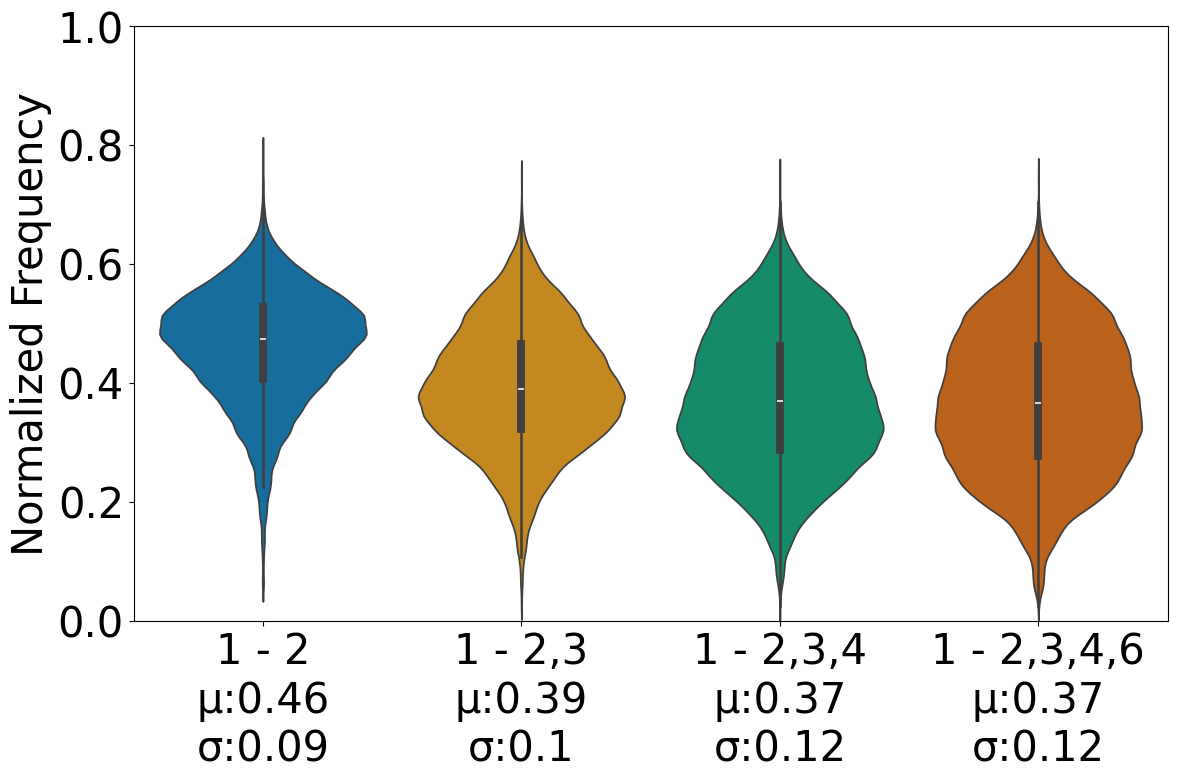

In [8]:
def function_common_terms_vs_others(group_df):
    global THE_MAIN_SEGMENT
    global epsilon
    # main_seg_score = group_df.loc[
    #     group_df["segment"].isin(THE_MAIN_SEGMENT), "sparse_matrix"
    # ].values

    main_seg_score = group_df.loc[
        group_df["segment"] == THE_MAIN_SEGMENT, "sparse_matrix"
    ].values
    other_seg_score = group_df.loc[
        group_df["segment"].isin(THE_OTHER_SEGMENT), "sparse_matrix"
    ].values

    # Calculate MAE between the first segment score and the rest of the segments
    if (
        len(main_seg_score) > 0 and len(other_seg_score) > 0
    ):  # Ensure there are other segments to compare
        main_seg_array = [main_seg_score[0].toarray()[0].astype(bool).astype(int)]
        # other_seg_array = other_seg_score[0].toarray()[0].astype(bool).astype(int)
        main_seg_array.extend(
            [i.toarray()[0].astype(bool).astype(int) for i in other_seg_score]
        )
        # main_seg_array = [
        #     i.toarray()[0].astype(bool).astype(int) for i in main_seg_score
        # ]
        # Stack the arrays for comparison
        stacked = np.stack(main_seg_array)
        common_indexes = np.where(
            np.all(stacked == stacked[0], axis=0) & (stacked[0] != 0)
        )[0]

        # Compute the function (e.g., MAE, or any custom function passed via FUNCTION_2_USE)
        function_value = common_indexes.shape[0] / stacked[0].sum()

        return function_value
    else:
        return None


pairs = [
    (1, [2]),
    (1, [2,3]),
    (1, [2,3,4]),
    (1, [2,3,4,6]),
]
folder_path = CACHE_MEMORY_PATH
results = [[] for _ in range(len(pairs))]
i = 0
total = len(os.listdir(folder_path))
how_many_files_to_see = 0.1
for files in os.listdir(folder_path):
    print("READING: \t", folder_path + "/" + files)
    s = time.time()

    df = pd.read_pickle(folder_path + "/" + files)
    df["segment"] = df["segment"].astype(int) + 1
    for index, pair in enumerate(pairs):
        result = compare(df, pair, function_common_terms_vs_others)
        results[index].append(result)
    del df
    gc.collect()
    i += 1
    print("time took:", time.time() - s)
    if i / total >= how_many_files_to_see:
        break

print("The results:")
all_dfs = []
for the_results, the_pair in list(zip(results, pairs)):
    # the_pair = [int(i) for i in the_pair[0]]
    # the_pair = tuple(the_pair)
    all_dfs.append((pd.concat(the_results, ignore_index=True), the_pair))
    print(f"Total number of documents for {the_pair} pair is:", all_dfs[-1][0].count())
create_plot(all_dfs,spacing=1)

UNIQUE TERMS

READING: 	 ./data/trec-robust04/cache_memory/part09.pkl
time took: 26.182491302490234
READING: 	 ./data/trec-robust04/cache_memory/part08.pkl
time took: 19.613551378250122
READING: 	 ./data/trec-robust04/cache_memory/part39.pkl
time took: 34.11812877655029
The results:
Total number of documents for (1, [2]) pair is: 12207
Total number of documents for (1, [2, 3]) pair is: 12207
Total number of documents for (1, [2, 3, 4]) pair is: 12207
Total number of documents for (1, [2, 3, 4, 6]) pair is: 12207


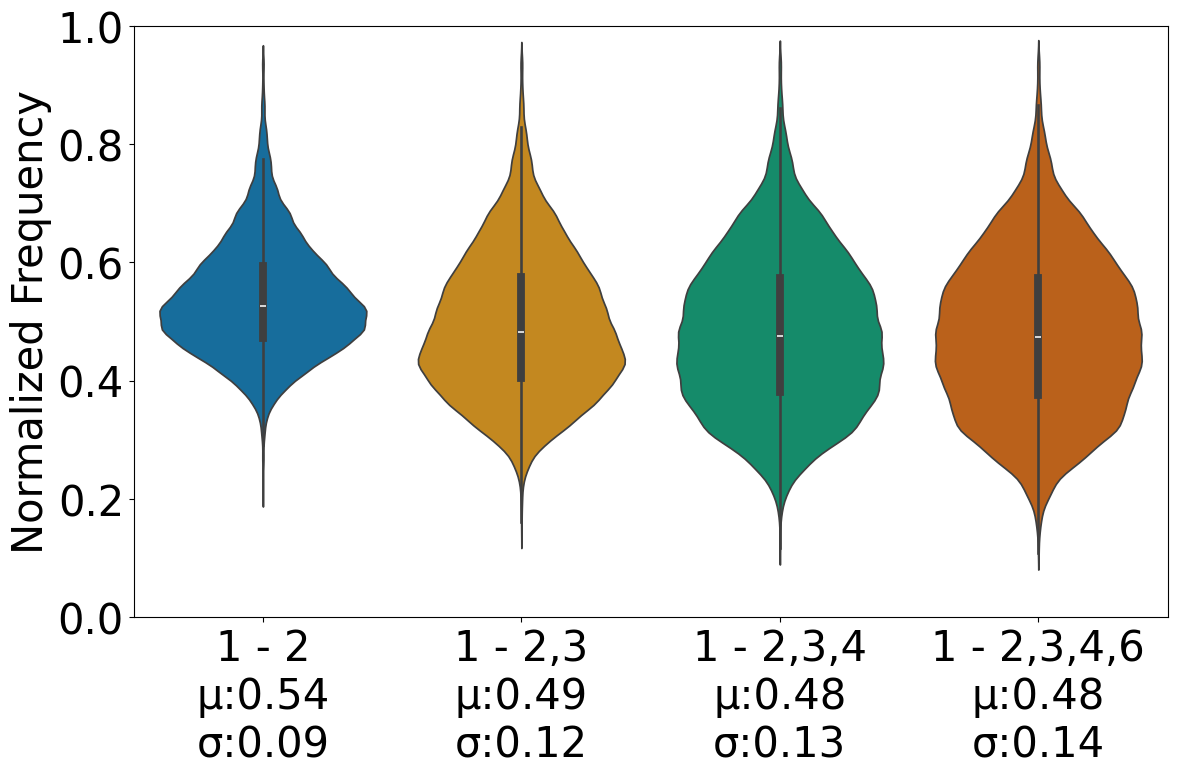

In [9]:
def function_common_terms_vs_others(group_df):
    global THE_MAIN_SEGMENT
    global THE_OTHER_SEGMENT
    main_seg_score = group_df.loc[
        group_df["segment"] == THE_MAIN_SEGMENT, "sparse_matrix"
    ].values
    other_seg_score = group_df.loc[
        group_df["segment"].isin(THE_OTHER_SEGMENT), "sparse_matrix"
    ].values

    # Calculate MAE between the first segment score and the rest of the segments
    if (
        len(main_seg_score) > 0 and len(other_seg_score) > 0
    ):  # Ensure there are other segments to compare
        main_seg_array = [
            i.toarray()[0].astype(bool).astype(int) for i in main_seg_score
        ]
        main_seg_array.extend(
            [i.toarray()[0].astype(bool).astype(int) for i in other_seg_score]
        )
        # Stack the arrays for comparison
        stacked = np.stack(main_seg_array)
        first_array = stacked[0]

        # Create a mask where the first array is non-zero
        non_zero_mask = first_array != 0

        # Check where first array has no common non-zero values with other arrays
        no_common_nonzero_mask = non_zero_mask & ~np.any(
            (stacked[1:] == first_array) & (stacked[1:] != 0), axis=0
        )

        function_value = no_common_nonzero_mask.sum() /first_array.sum()

        return function_value
    else:
        return None


pairs = [(1, [2]), (1, [2, 3]), (1, [2, 3, 4]), (1, [2, 3, 4, 6])]
folder_path = CACHE_MEMORY_PATH
results = [[] for _ in range(len(pairs))]
i = 0
total = len(os.listdir(folder_path))
how_many_files_to_see = 0.1
for files in os.listdir(folder_path):
    print("READING: \t", folder_path + "/" + files)
    s = time.time()

    df = pd.read_pickle(folder_path + "/" + files)
    df["segment"] = df["segment"].astype(int) + 1
    for index, pair in enumerate(pairs):
        result = compare(df, pair, function_common_terms_vs_others)
        results[index].append(result)
    del df
    gc.collect()
    i += 1
    print("time took:", time.time() - s)
    if i / total >= how_many_files_to_see:
        break

print("The results:")
all_dfs = []
for the_results, the_pair in list(zip(results, pairs)):
    all_dfs.append((pd.concat(the_results, ignore_index=True), the_pair))
    print(f"Total number of documents for {the_pair} pair is:", all_dfs[-1][0].count())
create_plot(all_dfs,spacing=1)

INFLUENCE

In [10]:
def find_common_indxes_and_uncommon_indexes(group_df):
    global THE_MAIN_SEGMENT
    global THE_OTHER_SEGMENT
    main_seg_score = group_df.loc[
        group_df["segment"] == THE_MAIN_SEGMENT, "sparse_matrix"
    ].values
    other_seg_score = group_df.loc[
        group_df["segment"].isin(THE_OTHER_SEGMENT), "sparse_matrix"
    ].values

    # Calculate MAE between the first segment score and the rest of the segments
    if (
        len(main_seg_score) == 1 and len(other_seg_score) >= 2
    ):  # Ensure there are other segments to compare

        main_seg_array = [
            i.toarray()[0].astype(bool).astype(int) for i in main_seg_score
        ]
        main_seg_array.extend(
            [i.toarray()[0].astype(bool).astype(int) for i in other_seg_score]
        )
        # Stack the arrays for comparison
        stacked = np.stack(main_seg_array)
        first_array = stacked[0]

        # Create a mask where the first array is non-zero
        non_zero_mask = first_array != 0

        # Check where first array has no common non-zero values with other arrays
        common_indexes_with_1st_a_2nd_a_3rd = np.where(
            np.all(stacked == stacked[0], axis=0) & (stacked[0] != 0)
        )[0]

        common_indexes_with_1st_a_2nd = np.where(
            non_zero_mask
            & (stacked[0] == stacked[1])
            & ~np.any((stacked[1:] == first_array))
        )[0]
        common_indexes_with_1st_a_3rd = np.where(
            non_zero_mask
            & (stacked[0] == stacked[2])
            & ~np.any((stacked[1:] == first_array))
        )[0]

        common_indexes_with_2nd_a_3rd = np.where(
            non_zero_mask
            & (stacked[1] == stacked[2])
            & ~np.any((stacked[1:] == first_array))
        )[0]

        only_first = np.where(
            non_zero_mask & ~np.any((stacked[1:] == first_array), axis=0)
        )[0]

        return (
            only_first,
            common_indexes_with_1st_a_2nd,
            common_indexes_with_1st_a_3rd,
            common_indexes_with_2nd_a_3rd,
            common_indexes_with_1st_a_2nd_a_3rd,
        )
    else:
        return [], [], [], [], []


pairs = [(1, [2, 3])]
folder_path = CACHE_MEMORY_PATH
qrels = pd.read_csv(QRELS_PATH, sep=" ", header=None)
qrels = qrels.rename(columns={0: "query", 2: "document"})
qrels[qrels[3] == 1]
qrel_documents = qrels.document.to_list()

i = 0
total = len(os.listdir(folder_path))
how_many_files_to_see = 1
results = [[] for _ in range(len(pairs))]
for files in os.listdir(folder_path):
    print("READING: \t", folder_path + "/" + files)
    s = time.time()

    df = pd.read_pickle(folder_path + "/" + files)
    # remove the ones that have only 2 segment
    document_counts = df['document'].value_counts()

    # Filter to keep only documents that appear more than 2s  
    documents_to_keep = document_counts[document_counts > 2].index

    # Filter the original DataFrame
    df = df[df['document'].isin(documents_to_keep)]

    df["segment"] = df["segment"].astype(int) + 1
    df = df[df["document"].isin(qrel_documents)]
    df = df[
        df["segment"].isin(
            list(
                set(
                    [item for sublist in pairs for item in sublist[1]]
                    + [item[0] for item in pairs]
                )
            )
        )
    ]
    for index, pair in enumerate(pairs):
        values = compare(df, pair, find_common_indxes_and_uncommon_indexes)
        df_merged = pd.merge(df, values.reset_index(), on="document", how="left")
        result = pd.merge(df_merged, qrels, on="document", how="inner")
        results[index].append(result)

    i += 1
    print("time took:", time.time() - s)
    if i / total >= how_many_files_to_see:
        break

READING: 	 ./data/trec-robust04/cache_memory/part09.pkl


time took: 3.0128490924835205
READING: 	 ./data/trec-robust04/cache_memory/part08.pkl
time took: 3.05802583694458
READING: 	 ./data/trec-robust04/cache_memory/part39.pkl
time took: 3.888538122177124
READING: 	 ./data/trec-robust04/cache_memory/part51.pkl
time took: 4.065107583999634
READING: 	 ./data/trec-robust04/cache_memory/part04.pkl
time took: 3.1090328693389893
READING: 	 ./data/trec-robust04/cache_memory/part28.pkl
time took: 3.9736249446868896
READING: 	 ./data/trec-robust04/cache_memory/part56.pkl
time took: 4.10234808921814
READING: 	 ./data/trec-robust04/cache_memory/part52.pkl
time took: 4.151110887527466
READING: 	 ./data/trec-robust04/cache_memory/part38.pkl
time took: 3.8276422023773193
READING: 	 ./data/trec-robust04/cache_memory/part03.pkl
time took: 3.3673336505889893
READING: 	 ./data/trec-robust04/cache_memory/part37.pkl
time took: 3.974153757095337
READING: 	 ./data/trec-robust04/cache_memory/part22.pkl
time took: 4.284078598022461
READING: 	 ./data/trec-robust04/c

In [11]:
query = pd.read_csv(QUERY_PATH, sep="\t", header=None)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=all_symbols)

query = query.rename(columns={0: "query", 1: "vector"})


# Step 1: Define a function that converts JSON sparse vector to sparse matrix
def json_to_sparse_vector(vector, all_symbols):
    index_mapping = {symbol: idx for idx, symbol in enumerate(all_symbols)}

    # Step 2: Initialize lists to store the row indices, column indices, and data values
    row_indices = []
    col_indices = []
    data_values = []

    # Step 3: Populate the lists based on `index_mapping`
    for row_idx, doc in enumerate(vector.split(" ")):
        words = doc.split()
        for word in words:
            if word in index_mapping:  # Only consider words in the index mapping
                col_idx = index_mapping[word]
                row_indices.append(0)
                col_indices.append(col_idx)
                data_values.append(
                    1
                )  # Assuming term frequency of 1 for each occurrence

    # Step 4: Create the COO sparse matrix
    num_rows = len(vector.split(" "))
    num_cols = len(all_symbols)
    return coo_matrix(
        (data_values, (row_indices, col_indices)), shape=(num_rows, num_cols)
    )


query["sparse_matrix"] = query["vector"].apply(
    lambda x: json_to_sparse_vector(x, all_symbols)
)

In [12]:
merged_df = pd.merge(pd.concat(results[0]), query, on="query", how="inner")

In [13]:
def the_function(group_df):
    # print(group_df)
    sparse_matrix_x = group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values
    sparse_matrix_y = group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values
    sparse_x = sparse_matrix_x[0].toarray()[0]
    sparse_y = sparse_matrix_y[0].toarray()[0]
    (
        only_first,
        common_indexes_with_1st_a_2nd,
        common_indexes_with_1st_a_3rd,
        common_indexes_with_2nd_a_3rd,
        common_indexes_with_1st_a_2nd_a_3rd,
    ) = group_df.loc[group_df["segment"] == 1, 0].values[0]

    if sparse_x.shape != sparse_y.shape:
        sparse_y = sparse_y[:-3]

    # Calculate the score for the 1st query
    score_1st = np.sum(group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values[0].toarray()[0] * 
                    group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values[0].toarray()[0])

    # Calculate the non-zero terms for each segment
    non_zero_1st = (group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values[0].toarray()[0] * 
                    group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values[0].toarray()[0]).nonzero()[0]
    non_zero_2nd = (group_df.loc[group_df["segment"] == 2, "sparse_matrix_x"].values[0].toarray()[0] * 
                    group_df.loc[group_df["segment"] == 2, "sparse_matrix_y"].values[0].toarray()[0]).nonzero()[0]
    non_zero_3rd = (group_df.loc[group_df["segment"] == 3, "sparse_matrix_x"].values[0].toarray()[0] * 
                    group_df.loc[group_df["segment"] == 3, "sparse_matrix_y"].values[0].toarray()[0]).nonzero()[0]

    # Calculate the intersection terms
    only_1st = set(non_zero_1st) - set(non_zero_2nd) - set(non_zero_3rd)
    only_2nd = set(non_zero_2nd) - set(non_zero_1st) - set(non_zero_3rd)
    only_3rd = set(non_zero_3rd) - set(non_zero_1st) - set(non_zero_2nd)
    only_1st_and_2nd = set(non_zero_1st) & set(non_zero_2nd) - set(non_zero_3rd)
    only_1st_and_3rd = set(non_zero_1st) & set(non_zero_3rd) - set(non_zero_2nd)
    only_2nd_and_3rd = set(non_zero_2nd) & set(non_zero_3rd) - set(non_zero_1st)
    only_1st_and_2nd_and_3rd = set(non_zero_1st) & set(non_zero_2nd) & set(non_zero_3rd)

    # Calculate the score for each term
    score_1st_term = np.sum([group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values[0].toarray()[0][i] * 
                            group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values[0].toarray()[0][i] for i in only_1st])
    score_2nd_term = np.sum([group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values[0].toarray()[0][i] * 
                            group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values[0].toarray()[0][i] for i in only_2nd])
    score_3rd_term = np.sum([group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values[0].toarray()[0][i] * 
                            group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values[0].toarray()[0][i] for i in only_3rd])
    score_1st_and_2nd_term = np.sum([group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values[0].toarray()[0][i] * 
                                    group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values[0].toarray()[0][i] for i in only_1st_and_2nd])
    score_1st_and_3rd_term = np.sum([group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values[0].toarray()[0][i] * 
                                    group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values[0].toarray()[0][i] for i in only_1st_and_3rd])
    score_2nd_and_3rd_term = np.sum([group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values[0].toarray()[0][i] * 
                                    group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values[0].toarray()[0][i] for i in only_2nd_and_3rd])
    score_1st_and_2nd_and_3rd_term = np.sum([group_df.loc[group_df["segment"] == 1, "sparse_matrix_x"].values[0].toarray()[0][i] * 
                                            group_df.loc[group_df["segment"] == 1, "sparse_matrix_y"].values[0].toarray()[0][i] for i in only_1st_and_2nd_and_3rd])

    # Calculate the percentage of the score for each term
    percentage_1st_term = (score_1st_term / score_1st) * 100
    percentage_2nd_term = (score_2nd_term / score_1st) * 100
    percentage_3rd_term = (score_3rd_term / score_1st) * 100
    percentage_1st_and_2nd_term = (score_1st_and_2nd_term / score_1st) * 100
    percentage_1st_and_3rd_term = (score_1st_and_3rd_term / score_1st) * 100
    percentage_2nd_and_3rd_term = (score_2nd_and_3rd_term / score_1st) * 100
    percentage_1st_and_2nd_and_3rd_term = (score_1st_and_2nd_and_3rd_term / score_1st) * 100


    # Prepare results based only on counts
    results = {
        "only_first": percentage_1st_term,
        # "only_second": percentage_2nd_term,
        # "only_third": percentage_3rd_term,
        # "common_first_and_second": percentage_1st_and_2nd_term,
        # "common_first_and_third": percentage_1st_and_3rd_term,
        "intersection": percentage_1st_and_2nd_term+ percentage_1st_and_3rd_term,
        # "common_second_and_third": percentage_2nd_and_3rd_term,
        "global_term": percentage_1st_and_2nd_and_3rd_term,
    }

    return results

# merged_df=merged_df[merged_df["document"]=="FBIS3-10169"]
result_of_merged_df = merged_df.groupby("document").apply(the_function)
df_plot = result_of_merged_df.reset_index()
df_plot[
    [
        "only_first",
        # "only_second",
        # "only_third",
        # "common_first_and_second",
        # "common_first_and_third",
        # "common_second_and_third",
        "intersection",
        "global_term",
    ]
] = pd.DataFrame(df_plot[0].tolist(), index=df_plot.index)

/scratch-local/elionis.9438174/ipykernel_1308831/3333749144.py:56: RuntimeWarning: invalid value encountered in scalar divide
  percentage_1st_term = (score_1st_term / score_1st) * 100
/scratch-local/elionis.9438174/ipykernel_1308831/3333749144.py:57: RuntimeWarning: invalid value encountered in scalar divide
  percentage_2nd_term = (score_2nd_term / score_1st) * 100
/scratch-local/elionis.9438174/ipykernel_1308831/3333749144.py:58: RuntimeWarning: invalid value encountered in scalar divide
  percentage_3rd_term = (score_3rd_term / score_1st) * 100
/scratch-local/elionis.9438174/ipykernel_1308831/3333749144.py:59: RuntimeWarning: invalid value encountered in scalar divide
  percentage_1st_and_2nd_term = (score_1st_and_2nd_term / score_1st) * 100
/scratch-local/elionis.9438174/ipykernel_1308831/3333749144.py:60: RuntimeWarning: invalid value encountered in scalar divide
  percentage_1st_and_3rd_term = (score_1st_and_3rd_term / score_1st) * 100
/scratch-local/elionis.9438174/ipykernel_13

<Figure size 1200x800 with 0 Axes>

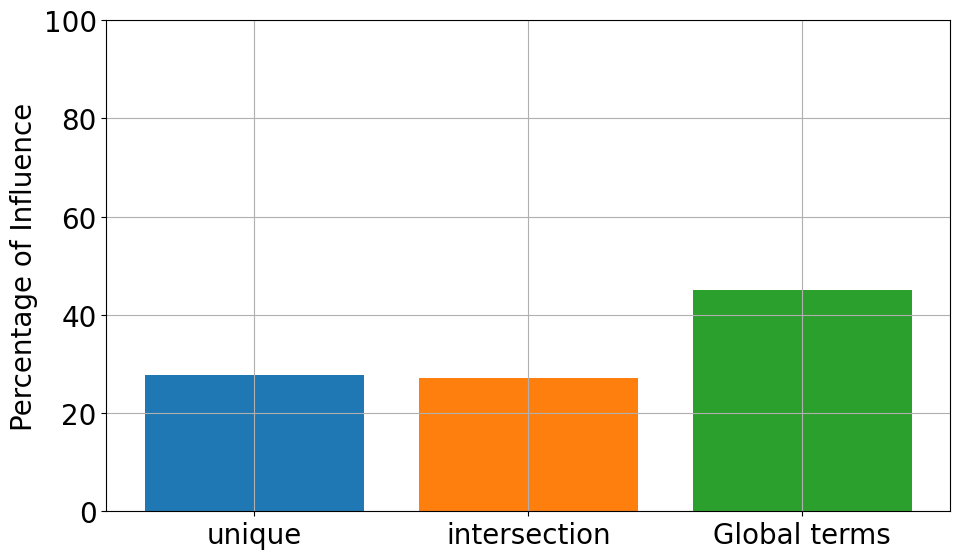

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

kwargs = dict(hist_kws={"alpha": 0.25}, kde_kws={"linewidth": 2.5})

plt.rcParams.update({"font.size": 20})  # Set to your desired size

plt.figure(figsize=(12, 8))

label_mapping={
    "only_first":"unique",
    # "only_second":"2nd",
    # "only_third":"3rd",
    # "common_first_and_second":"intersection",
    "intersection":"intersection",
    # "common_first_and_third":"intersection(1st seg, 3nd seg)",
    # "common_second_and_third":"2∩3",
    "global_term": "Global terms"
}

colors = sns.color_palette("colorblind", len(list(label_mapping.values())))


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

total = sum(df_plot[column].sum() for column in label_mapping.keys())

# Step 3: Create the main distribution plot
for i, column in enumerate(
    [
        "only_first",
        # "only_second",
        # "only_third",
        # "common_first_and_second",
        # "common_first_and_third",
        "intersection",
        # "common_second_and_third",
        "global_term",
    ]
):
    ax.bar([i], [df_plot[column].sum()/total*100], width=0.8)

ax.set_ylabel('Percentage of Influence')
ax.set_xticks(np.arange(len(label_mapping)))
ax.set_xticklabels(label_mapping.values())
ax.set_ylim([0, 100])


# Show the plot
plt.grid()
plt.tight_layout()
plt.show()
